# Récupération et affichage d'images optiques.

Les images optiques sont créées par le capteur OCLI de Sentinel 3. Nous allons récupérer des images prétraitées par GLS sur l'ensemble du globe et extraire des zones géographiques qui nous intéressent.

<mark>Pour que ce travail soit effectif il vous faudra au moins deux téléchargement de données FCOVER300 dans votre répertoire "data/zones/_Earth/FCOVER".</mark>

_Version 1.3 [25/02/2023] Jérôme Lacaille_

In [1]:
import os
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
%matplotlib inline

# On élargit un peu les fenêtres d'affichage de matplotlib.
plt.rcParams["figure.figsize"] = (9,6)

On importe notre package et on s'assure qu'on peut le modifier de manière interactive.

In [2]:
import satellite as sat


In [3]:
%reload_ext autoreload
%autoreload 2

Juste pour s'assurer que tout va bien on charge une liste de zones. Vous pouvez regarder les zones que j'ai choisies, mais vous pouvez très bien,pour la suite utiliser des zones définies par vous-mêmes.

In [4]:
gz = sat.GeoZone('map.geojson')
zone = gz[2]
zone

{'name': 'Crete',
 'bbox': [34.85709260445668,
  23.397028867484522,
  35.631415093017225,
  26.44578481885614]}

## 1. Compréhension du stockage des images.
Dans les lignes suivantes nous allons charger des images "netCDF" et afficher leurs valeurs sur les zones géographiques qui nous intéressent.

## 1.1 Détails des données disponibles.
Créons une table contenant pour chaque ligne la date de création "DATE", le chemin du fichier "FILE" et le numéro de révision par GLS "REVISION".

In [5]:
# On se souvient que le répertoire "EARTHDIR" contient les données de la terre.
# Or nous avons stocké les images dans un sous répertoire FCOVER d ece chemin.
sat.EARTHDIR

'C:\\Users\\sophi\\Desktop\\MACS2\\Analyse_de_donnee\\satellite\\data/zones/_Earth/'

In [6]:
rawdir = sat.EARTHDIR + "FCOVER/"
rawdir

'C:\\Users\\sophi\\Desktop\\MACS2\\Analyse_de_donnee\\satellite\\data/zones/_Earth/FCOVER/'

Récupérons la liste des fichiers .nc.
J'utilise usuellement le module "os", mais vous pouvez aussi installer "pathlib".

> [Documentation du module os](https://docs.python.org/fr/3/library/os.html)

In [7]:
# Gestion des fichiers et dossiers.
import os

In [8]:
# Les dossiers téléchargés.
os.listdir(rawdir)

['c_gls_FCOVER300-RT0_202401100000_GLOBE_OLCI_V1.1.2.nc',
 'c_gls_FCOVER300-RT0_202401200000_GLOBE_OLCI_V1.1.2.nc',
 'c_gls_FCOVER300-RT0_PROD-DESC_202401100000_GLOBE_OLCI_V1.1.2.xml',
 'c_gls_FCOVER300-RT0_PROD-DESC_202401200000_GLOBE_OLCI_V1.1.2.xml',
 'c_gls_FCOVER300-RT0_PROD-DESC_202401310000_GLOBE_OLCI_V1.1.2.xml',
 'c_gls_FCOVER300-RT0_QL_202401100000_GLOBE_OLCI_V1.1.2.tiff',
 'c_gls_FCOVER300-RT0_QL_202401200000_GLOBE_OLCI_V1.1.2.tiff',
 'c_gls_FCOVER300-RT0_QL_202401310000_GLOBE_OLCI_V1.1.2.tiff',
 'c_gls_FCOVER300-RT2_202312310000_GLOBE_OLCI_V1.1.2.nc',
 'c_gls_FCOVER300-RT2_202401100000_GLOBE_OLCI_V1.1.2.nc',
 'c_gls_FCOVER300-RT2_PROD-DESC_202312310000_GLOBE_OLCI_V1.1.2.xml',
 'c_gls_FCOVER300-RT2_PROD-DESC_202401100000_GLOBE_OLCI_V1.1.2.xml',
 'c_gls_FCOVER300-RT2_QL_202312310000_GLOBE_OLCI_V1.1.2.tiff',
 'c_gls_FCOVER300-RT2_QL_202401100000_GLOBE_OLCI_V1.1.2.tiff',
 'c_gls_FCOVER300-RT6_202311200000_GLOBE_OLCI_V1.1.2.nc',
 'c_gls_FCOVER300-RT6_202311300000_GLOBE_OLCI_V1.1

Parcourrez l'ensemble de ces dossiers pour ne lister que les fichiers netCDF.

_Astuce : utilisez `os.walk` et `os.endwith`._

In [9]:
# Les fichiers .nc
listfiles = []
for froot,fdir,fnames in os.walk(rawdir):
    for fname in fnames:
        if fname.endswith('.nc'):
            listfiles.append(fname)
listfiles

['c_gls_FCOVER300-RT0_202401100000_GLOBE_OLCI_V1.1.2.nc',
 'c_gls_FCOVER300-RT0_202401200000_GLOBE_OLCI_V1.1.2.nc',
 'c_gls_FCOVER300-RT2_202312310000_GLOBE_OLCI_V1.1.2.nc',
 'c_gls_FCOVER300-RT2_202401100000_GLOBE_OLCI_V1.1.2.nc',
 'c_gls_FCOVER300-RT6_202311200000_GLOBE_OLCI_V1.1.2.nc',
 'c_gls_FCOVER300-RT6_202311300000_GLOBE_OLCI_V1.1.2.nc',
 'c_gls_FCOVER300-RT6_202312100000_GLOBE_OLCI_V1.1.2.nc']

Récupérez le dernier fichier.

_Astuce : utilisez "`_`"._

In [10]:
# Petite astuce : _ correspond aux dernier résultat affiché.
filename = _[-1]
filename

'c_gls_FCOVER300-RT6_202312100000_GLOBE_OLCI_V1.1.2.nc'

#### Les expressions régulières

On voudrait extraire la révision et la date du nom du fichier. beaucoup de données sont transmises sous une forme textuelle et il est habituel de passer beaucoup de temps à transformer ces données (_les encoder_) pour les rendre intelligibles par nos outils d'analyse. On utilise des outils de transformations, et parmi eux, la gestion d'expressions régulières est sans doute le plus fréquemment exploité.

> [Documentation sur les experssions régulières](https://docs.python.org/fr/3/library/re.html)

Dans notre exemple nous nous contentons d'un cas assez simple qui consiste à extraire et traduire des champs codés dans le nom des fichiers (un nombre et une date). Souvent il est plus malin de stocker  ces informations à l'intérieur du fichier sous la forme de méta données, par exemple dans une entête, mais c'est rarement le cas.

In [11]:
# Gestion des expressions régulières.
import re

Notre recherche prend donc le nom du fichier en entrée et définit un pattern formé de deux _groupes_. Les groupes sont définis par des sous-patterns entre parenthèses (pour _échapper_ un caractère de contrôle comme une parenthèse par exemple il suffit de le précéder de la contre-oblique '\', mais on n'en a pas besoin ici).

<mark>Je vous laisse le code pour que vous ne perdiez pas trop de temps, mais vous devez expérimenter un peu par vous même.</mark>

In [12]:
# Pour extraire la révision et la date on recherche un pattern RT0_YYYYMMDD0*_ avec un chiffre à la place du 0.
print("Le nom du fichier :", filename)

# On lance la recherche du pattern contenant deux groupes.
m = re.search('(RT[0-9])_([0-9]+)_',filename)

print('m=',m)
# On affiche le contenu du résultat (m).
print("Nombre de groupes :", m.lastindex)
print("La chaine entière :", m[0])
print("Le premier groupe :", m[1])
print("Le second groupe  :", m[2])
print("Tous les groupes  :", m.groups())

Le nom du fichier : c_gls_FCOVER300-RT6_202312100000_GLOBE_OLCI_V1.1.2.nc
m= <re.Match object; span=(16, 33), match='RT6_202312100000_'>
Nombre de groupes : 2
La chaine entière : RT6_202312100000_
Le premier groupe : RT6
Le second groupe  : 202312100000
Tous les groupes  : ('RT6', '202312100000')


#### Format des dates.

On veut le numéro de révision et une date Python.
Pour la date je vous conseille `pd.to_datetime(chaine,format)` car on va créer une table pandas et que cette fonction admet des paramètres de format.

La date peut être directement définie par pandas, mais vous pouvez aussi utiliser le module "datetime" de Python. Il définit des objets comme `datetime` et `timedelta` que l'on avait déjà vu alors que pandas produit des `Timestamp`.

Ce n'est pas très génant en fait car quand on va insérer des `datetime` dans une table pandas il va les transformer automatiquement en `Timestamp`, et les manipulation de `Timestamp` sont prévues dans le package datetime.

In [13]:
from datetime import datetime

In [14]:
revision = int(m[1][2])
date = datetime.strptime(m[2],'%Y%m%d%H%M')
date2 = pd.to_datetime(m[2],format='%Y%m%d%H%M')
revision,date, date2

(6, datetime.datetime(2023, 12, 10, 0, 0), Timestamp('2023-12-10 00:00:00'))

#### Créer la table en parcourant la liste des fichiers.

* Attention, si deux fichiers sont datés du même jour, nous ne devons garder que celui qui a la révision la plus élevée.
* Ne pas oublier de mettre le chemin complet en rajoutant le répertoire contenant le fichier.

<mark>À vous de construire la table.</mark>

In [15]:
# On crée la table df contenant la liste des fichiers.
N = []
D = []
RT = []
for froot,fdir,fnames in os.walk(rawdir):
    for filename in fnames:
        if filename.endswith('.nc'):
            m = re.search('(RT[0-9])_([0-9]+)_',filename) 
            rt = int(m[1][2])
            d = pd.to_datetime (m[2],format = '%Y%m%d%H%M')
            if d in D:
                i = D.index(d)
                if rt>RT[i]:
                    D[i] = d
                    RT[i] = rt
                    N[i] = os.path.join(froot,filename)
            else:
                N.append(os.path.join(froot,filename))
                D.append(d) 
                RT.append(rt) 
            

df = pd.DataFrame({'DATE': D, 'FILE' : N, 'REVISION' : RT})
print(df)

        DATE                                               FILE  REVISION
0 2024-01-10  C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...         2
1 2024-01-20  C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...         0
2 2023-12-31  C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...         2
3 2023-11-20  C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...         6
4 2023-11-30  C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...         6
5 2023-12-10  C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...         6


In [16]:
# Liste des fichiers disponibles.
df['FILE'][1]

'C:\\Users\\sophi\\Desktop\\MACS2\\Analyse_de_donnee\\satellite\\data/zones/_Earth/FCOVER/c_gls_FCOVER300-RT0_202401200000_GLOBE_OLCI_V1.1.2.nc'

Mettre la date en index et triez la table par date croissante.

In [17]:
# On met la date en index.
df.index = df['DATE']

# Du coup on n'a plus besoin de la colonne correspondate.
df.drop(columns="DATE",inplace=True)

# Finalement on trie la table.
df.sort_index(inplace=True)
df

,FILE,REVISION
DATE,,
2023-11-20,C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...,6
2023-11-30,C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...,6
2023-12-10,C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...,6
2023-12-31,C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...,2
2024-01-10,C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...,2
2024-01-20,C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...,0


## 1.2 Analyse du contenu d'un fichier.
Les fichiers récupérés par GLS sont un peu différents des tables habituelles en analyse de données. On va en explorer le contenu, récupérer des informations sur une zone géographique et faire quelques calculs.

Récupérons le premier fichier.

In [18]:
img = 2
fname = df.FILE[img]
print(fname)

C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee\satellite\data/zones/_Earth/FCOVER/c_gls_FCOVER300-RT6_202312100000_GLOBE_OLCI_V1.1.2.nc


Les fichiers ".nc" sont des fichiers netCDF qui nécessitent un package spécial pour les charger (netcdf4). Nous aurons besoins de l'objets `Dataset` qui contient l'image.

> [netCDF (Network Comon Data Form)](https://fr.wikipedia.org/wiki/NetCDF)

> [Documentation de netcdf4](https://unidata.github.io/netcdf4-python/#variables-in-a-netcdf-file)

In [19]:
# Import spécifique à la gestion des images.

from netCDF4 import Dataset

On affiche quelques éléments de compréhension...

_Attention, ici on va garder la ressource `nc` ouverte pour se faciliter l'étude, mais en général on essayera plutôt d'encadrer la ressource d'un groupe `with` ou d'une reprise sur erreur._

In [20]:
nc = Dataset(fname, 'r')

In [21]:
print("Dimensions:\n", nc.dimensions)
print("Variables:\n", nc.variables.keys())
print("FCOVER dimensions:", nc.variables['FCOVER'].dimensions)
print("lat dimension:",nc.variables['lat'].dimensions)
print(type(nc))
fcover = nc.variables['FCOVER'][0,0:3,0:3]
fcover

Dimensions:
 {'lon': <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 120960, 'lat': <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 47040, 'time': <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 1}
Variables:
 dict_keys(['FCOVER', 'LENGTH_AFTER', 'LENGTH_BEFORE', 'NOBS', 'QFLAG', 'RMSE', 'crs', 'lat', 'lon', 'time'])
FCOVER dimensions: ('time', 'lat', 'lon')
lat dimension: ('lat',)
<class 'netCDF4._netCDF4.Dataset'>


masked_array(
  data=[[--, --, --],
        [--, --, --],
        [--, --, --]],
  mask=[[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],
  fill_value=255,
  dtype=float64)

In [22]:
nc.variables['FCOVER'].dimensions

('time', 'lat', 'lon')

In [23]:
nc.variables['time'].dimensions

('time',)

L'ordre des variables dans la dimension correspond à celui d'une image, donc la première dimension et Y et pas X.

In [24]:
(nc.variables['time'].axis,nc.variables['lat'].axis, nc.variables['lon'].axis)

('T', 'Y', 'X')

Une chance ! Les unités correspondent bien à ce dont on a l'habitude.

In [25]:
(nc.variables['time'].units, nc.variables['lon'].units,nc.variables['lat'].units)

('days since 1970-01-01 00:00:00', 'degrees_east', 'degrees_north')

Affichez le détail de la variable FCOVER.

In [26]:
nc.variables['FCOVER'] 

<class 'netCDF4._netCDF4.Variable'>
uint8 FCOVER(time, lat, lon)
    _FillValue: 255
    standard_name: vegetation_area_fraction
    long_name: Fraction of green Vegetation Cover 333m
    grid_mapping: crs
    scale_factor: 0.004
    add_offset: 0.0
    units: 
    valid_range: [  0 250]
    missing_value: 255
unlimited dimensions: time
current shape = (1, 47040, 120960)
filling on

Maintenant on va extraire la partie de l'image correspondant à notre zone.

_Notez que si une instruction Python renvoie un objet qui est itérable (une liste par exemple) vous pouvez directement déployer les premiers éléments dans des variables individuelles._

In [27]:
lat0,lon0,lat1,lon1 = zone['bbox']

In [28]:
lat0,lon0,lat1,lon1

(34.85709260445668, 23.397028867484522, 35.631415093017225, 26.44578481885614)

In [29]:
# Les latitudes et longitudes sont jamais masquées, on peu récupérer les valeurs directement. Comme ce sont des dimensions, elles sont scalaires.
lon = nc.variables['lon'][:].data
lat = nc.variables['lat'][:].data
lat

array([ 80.        ,  79.99702381,  79.99404762, ..., -59.99107143,
       -59.99404762, -59.99702381])

En utilisant un "et" logique `np.logical_and` récupérez le contenu de notre zone d'intérêt.

In [30]:
bx = np.logical_and(lon0<=lon, lon<=lon1)
by = np.logical_and(lat0<=lat, lat<=lat1)
fc = nc.variables['FCOVER'][0,by,bx]
fc

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=255)

Remplacez les valeurs masquées par des `np.nan` et affichez l'image avec `plt.imshow()`.

In [31]:
F = fc.data
F[fc.mask] = np.nan
F

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

Maintenant on peut afficher l'image.

Text(0.5, 1.0, 'Crete [FCOVER] le 10/12/2023')

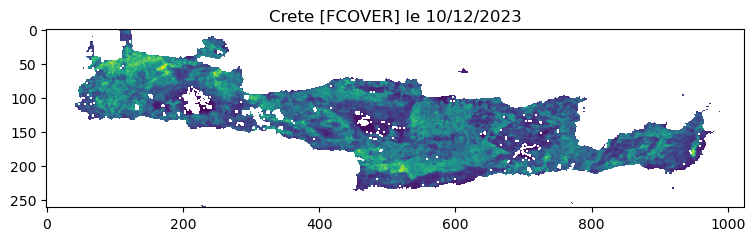

In [32]:
plt.imshow(F)
plt.title(zone['name'] + " [FCOVER] le " + df.index[img].strftime('%d/%m/%Y'))

<mark>N'oubliez pas de fermer la ressource.</mark>

In [33]:
# Fermeture de la ressource.
nc.close()

## 2. Affichage interactif.

Nous allons essayer de construire un affichage permettant de changer interactivement la zone affichée.

### 2.1 Accès par le nom de la zone.

Nous aimerions pouvoir sélectionner la zone à afficher à partir de son nom.
Pour cela nous allons rajouter une méthode `bboxbyname` à l'objet GeoZone pour récupérer la bbox depuis le nom.

Commençons comme d'habitude par tester une telle méthode sur le notebook. 

<mark>Complétez cette fonction pour qu'elle se comporte comme attendu dans les deux cellules suivantes.</mark>

In [34]:
def bboxbyname(self, name):
    """ BBOXBYNAME - Récupération des coordonnées à partir du nom.
    """
    for z in self.Z:
        if z['name'] == name:
            return z['bbox']
    raise sat.geozone.GeofileException(f"La zone {name} n'existe pas.")

In [35]:
bboxbyname(gz,'Barcelone')

[41.22007856049126, 1.6649881237897546, 41.63394152808198, 2.4690345841926273]

### 2.2 Ajout de la fonction à l'objet.

Cette fois, plus besoin de passer l'objet en argument, il arrive avant l'appel de la fonction.
Pensez à l'aide et à la gestion des erreurs.

<mark>Vous devez rajouter la méthode à l'objet `GeoZone` de votre module geozone.py.</mark>

In [36]:
print(gz.bboxbyname.__doc__)

 BBOXBYNAME - Récupération des coordonnées à partir du nom.
        


In [37]:
gz.bboxbyname('Barcelone')

[41.22007856049126, 1.6649881237897546, 41.63394152808198, 2.4690345841926273]

On montre ici qu'on peut intercepter une exception et l'imprimer.
La fonction `__repr__` de l'exception ValueError affiche le message passé en argument, pour les autres composants, il suffit d'appeler les différents champs.

<mark>Votre code dans geozone.py doit gérer les exceptions.</mark>

In [38]:
try:
    gz.bboxbyname("ZoneInconnue")
except sat.geozone.GeofileException as e:
    print(e.__class__, e)
    print(e.__doc__)

<class 'satellite.geozone.GeofileException'> La zone ZoneInconnue n'existe pas.
 Exception raised when geofile is bad.


### 2.3 Récupération d'un fichier à partir d'une date.

Pour accéder à l'image à charger on veut pouvoir se contenter de choisir une date. Si possible on aimerait afficher cette date comme en français en jour-mois-année.

In [39]:
# Rappel : on a la liste des fichiers sous forme de table.
df

,FILE,REVISION
DATE,,
2023-11-20,C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...,6
2023-11-30,C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...,6
2023-12-10,C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...,6
2023-12-31,C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...,2
2024-01-10,C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...,2
2024-01-20,C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...,0


In [40]:
# On a les dates.
df.index

DatetimeIndex(['2023-11-20', '2023-11-30', '2023-12-10', '2023-12-31',
               '2024-01-10', '2024-01-20'],
              dtype='datetime64[ns]', name='DATE', freq=None)

In [41]:
# On veut récupérer les dates au bon format.
d0 = df.index[0]
print("Date initiale :", d0)
print("Date formatée :", d0.strftime('%d-%m-%Y'))

Date initiale : 2023-11-20 00:00:00
Date formatée : 20-11-2023


On peut finalement créer la liste des dates.

In [42]:
datelist = [d.strftime('%d-%m-%Y') for d in df.index]
datelist

['20-11-2023',
 '30-11-2023',
 '10-12-2023',
 '31-12-2023',
 '10-01-2024',
 '20-01-2024']

Il va aussi falloir pouvoir retrouver le chemin du fichier à partir de la date.

<mark>Ecrivez une fonction qui fait cela.</mark>

_Astuce : utilisez la méthode `index` d'une liste._

In [43]:
def ncfilebydate(df, date):
    for d in df.index:
        if d.strftime('%d-%m-%Y') == date:
            i = datelist.index(date)
    return df.FILE[i]

In [44]:
ncfilebydate(df,datelist[0])

'C:\\Users\\sophi\\Desktop\\MACS2\\Analyse_de_donnee\\satellite\\data/zones/_Earth/FCOVER/c_gls_FCOVER300-RT6_202311200000_GLOBE_OLCI_V1.1.2.nc'

In [45]:
ncfilebydate(df,'31-12-2023')

'C:\\Users\\sophi\\Desktop\\MACS2\\Analyse_de_donnee\\satellite\\data/zones/_Earth/FCOVER/c_gls_FCOVER300-RT2_202312310000_GLOBE_OLCI_V1.1.2.nc'

### 2.4 Récupération des données de l'image.

Dans cette section on va reprendre le code que l'on a vu précédemment pour récupérer les données de l'image FCOVER d'une zone sous la forme d'un tableau numpy.

In [46]:
# On récupère la liste des noms.
names = [z['name'] for z in gz]
names

['Ile de France', 'Barcelone', 'Crete', 'Moyen Atlas']

On commence par créer une fonction qui récupère l'image.

<mark>Complétez cette fonction avec ce que l'on a appris plus haut.</mark>

In [47]:
def nczimage(date,name):
    lat0,lon0,lat1,lon1 = gz.bboxbyname(name)
    fname = ncfilebydate(df,date)
    
    with Dataset(fname, 'r') as nc:
        # Cacul des coordonnées utiles.
        lon = nc.variables['lon'][:].data
        lat = nc.variables['lat'][:].data

        # Extraction des données FCOVER.
        bx = np.logical_and(lon0<=lon, lon<=lon1)
        by = np.logical_and(lat0<=lat, lat<=lat1)
        fc = nc.variables['FCOVER'][0,by,bx]
        # On gère le masque par des NaN.
        F = fc.data
        
        F[fc.mask] = np.nan
    
    return F

In [48]:
F = nczimage(datelist[0],names[2])

Profitons en pour calculer la moyenne du taux de végétation sur la zone.

In [49]:
m = np.nanmean(F)
print(f"Taux de couverture végétale moyen : {100*m:.1f}%.")

Taux de couverture végétale moyen : 22.8%.


### 2.3 Utilisation des widgets.

Le package ipywidgets permet de créer des interactions sous Jupyter.

In [50]:
import ipywidgets as widgets

Ecrire une fonction qui pernd en entrée une date et un nom de zone et qui affiche l'image. On utilise les calculs précédents.

<mark>Complétez la fonction</mark>

In [51]:
def nczplot(date,name):
    F = nczimage(date,name)
    plt.imshow(F);
    m = np.nanmean(F)
    plt.title(name + " [FCOVER] le " + date + "avec un " + f"taux de couverture végétale moyen : {100*m:.1f}%.");
    plt.show();

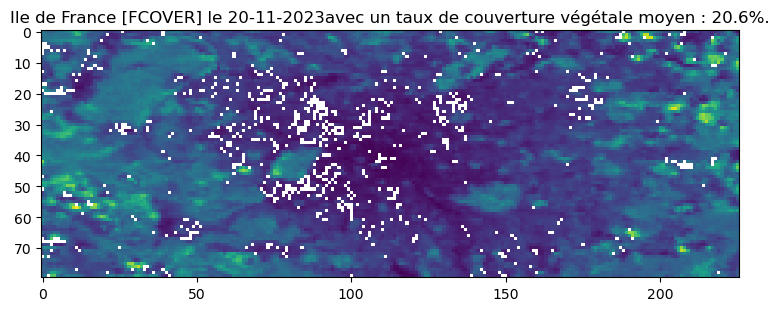

In [52]:
nczplot(datelist[0],names[0])

L'api de ipywidgets dispose de plusieurs modes qu'ils vous faudra découvrir en regardat la doc.

> [Documentation de ipywidgets](https://ipywidgets.readthedocs.io/en/stable/)

In [53]:
import ipywidgets as widgets

In [54]:
widgets_interact = widgets.interact(nczplot, date=datelist, name=names);
display (widgets_interact);

interactive(children=(Dropdown(description='date', options=('20-11-2023', '30-11-2023', '10-12-2023', '31-12-2…

<function __main__.nczplot(date, name)>

Vous pouvez jouer avec les deux listes ci dessus.

## 3. Créer le module ocli avec la classe Ocli.

Ce que l'on vient de faire est un peu fouilli, on traine des variables globales comme la liste de dates, la liste de noms, le tableau des fichiers et la GeoZone. Il faudrait rassembler tout cela au sein d'une même classe bien propre. Comme les fichiers de données sont toujours les mêmes et sont stockés dans un répertoire fixe `rawdir`qui sera mis par défaut à `sat.FCOVERDIR`, on peut dériver la classe Ocli de GeoZone. 

_Faites attention à la documentation, aux gestions d'erreurs, etc._

Créez le module ocli.py qui contient les fonctions et la classe qui va bien pour mieux gérer cet affichage. 

<mark> La suite de ce notebook donne un certain nombre de résultats. J'attends que votre classe renvoie la même chose. Pensez à garder une copie des résultats attendus.</mark>

Vous aurez sans doute besoin de tester votre classe plusieurs fois, je vous conseille de créer un notebook séparé pour pouvoir recharger le noyau python et réexécuter le code car la fonction magique %autoreload nemarche pas très bien quand on modifie le contenu d'une classe.

<mark>Si vous en êtes ici, vous n'aurez plus besoin de modifier quoi que ce soit au notebook. Il sert à présent juste à vérifier le code que vous allez programmer dans le module ocli.py.</mark>

### 3.1 Construire un module bien propre.

Notez en passant qui est malin de rajouter quelques éléments de documentation à un module qui vont compléter les champs de base comme `__file__` ou `__doc__`.

In [55]:
print(sat.ocli.__doc__)
print("  fichier :", sat.ocli.__file__)
print("  date    :", sat.ocli.__date__)
print("  version :", sat.ocli.__version__)


OCLI - Outil d'extraction des données Optiques.

Votre travail est de construire ce module. Il correspond à la section 3
du notebook ocli_doc.ipynb.
J'ai quand même laissé quelques détails avec diverses explications
pour vous aider à démarrer.

@author: Jérôme Lacaille

  fichier : C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee\satellite\ocli.py
  date    : 2023-02-25
  version : 1.1


In [56]:
# Le répertoire par défaut FCOVERDIR.
sat.FCOVERDIR

'C:\\Users\\sophi\\Desktop\\MACS2\\Analyse_de_donnee\\satellite\\data/zones/_Earth/FCOVER/'

In [57]:
# Créer la fonction de module permettant de récupérer la table des fichiers.
sat.ocli.getncfiles(rawdir)

,FILE,REVISION
DATE,,
2023-11-20,C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...,6
2023-11-30,C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...,6
2023-12-10,C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...,6
2023-12-31,C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...,2
2024-01-10,C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...,2
2024-01-20,C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...,0


On crée une fonction qui renvoie la table des fichiers et qui sera appelée lors de l'initialisation de la classe.

Comme précédemment, la liste de zones par défaut est "map.geojson".

### 3.2 Création de l'objet Ocli.

_(J'ai préparé l'instanciation de la classe, notez l'appel de  `super()` pour instancier la clase de base.)_

N'oubliez pas d'exporter l'objet Ocli.

In [58]:
# On crée l'objet Ocli et on affiche son détail.
oc = sat.Ocli()
oc

Ocli (map.geojson) - Liste de 4 GeoZones

In [59]:
# On a stocké la table des données à l'initialisation.
oc.df

,FILE,REVISION
DATE,,
2023-11-20,C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...,6
2023-11-30,C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...,6
2023-12-10,C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...,6
2023-12-31,C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...,2
2024-01-10,C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...,2
2024-01-20,C:\Users\sophi\Desktop\MACS2\Analyse_de_donnee...,0


In [60]:
# Toujours à l'initialisation on a préparé les listes de noms et de dates.
print(oc.names)
print(oc.dates)

['Ile de France', 'Barcelone', 'Crete', 'Moyen Atlas']
['20-11-2023', '30-11-2023', '10-12-2023', '31-12-2023', '10-01-2024', '20-01-2024']


In [61]:
# On a créé une fonction permettant de récupérer un fichier depuis sa date.
oc.ncfilebydate(oc.dates[0])

'C:\\Users\\sophi\\Desktop\\MACS2\\Analyse_de_donnee\\satellite\\data/zones/_Earth/FCOVER/c_gls_FCOVER300-RT6_202311200000_GLOBE_OLCI_V1.1.2.nc'

In [62]:
# Pour les coordonnées, on avait déjà fait le travail, donc la hierarchie appelle directement la foction de GeoZone.
oc.bboxbyname(oc.names[0])

[48.7535883521073, 2.0085203859495095, 48.99193420772434, 2.6788390690815334]

In [63]:
# On peut récupérer le tableau de valeurs.
print(oc.names[0])
oc.values(oc.dates[0],oc.names[0])

Ile de France


array([[0.328, 0.288, 0.264, ..., 0.3  , 0.124, 0.06 ],
       [0.32 , 0.324, 0.296, ..., 0.288, 0.264, 0.164],
       [0.292, 0.328, 0.32 , ..., 0.256, 0.32 , 0.416],
       ...,
       [0.264, 0.264, 0.276, ..., 0.136, 0.14 , 0.216],
       [0.248, 0.24 , 0.344, ..., 0.192, 0.196, 0.22 ],
       [0.3  , 0.352,   nan, ..., 0.184, 0.172, 0.228]])

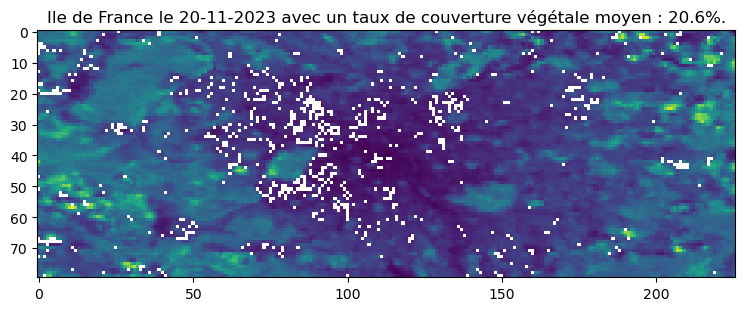

In [64]:
# Une méthode plot() permet d'afficher l'image.
oc.plot(oc.dates[0],oc.names[0])

In [65]:
# Cette méthode peut être appelée interactivement.
widgets.interact(oc.plot, date=oc.dates, name=oc.names)

interactive(children=(Dropdown(description='date', options=('20-11-2023', '30-11-2023', '10-12-2023', '31-12-2…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

Très facile : essayer maintenant de construire une méthode `iplot()` qui exécute automatiquement l'interactivité, sans avoir à passer de paramètres.

In [66]:
oc.iplot()

interactive(children=(Dropdown(description='date', options=('20-11-2023', '30-11-2023', '10-12-2023', '31-12-2…

In [67]:
oc.FCOVER('Ile de France')
oc.FCOVER('Moyen Atlas')

C'est fini !

_Jérôme Lacaille_